In [241]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [242]:
#Checking wich GPU is beeing used

!nvidia-smi

Thu Nov 18 11:34:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   29C    P8    18W / 250W |   6801MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [244]:
#Load data
data_file = 'dialogue/Dataset/VoiceDetection/Output.npy'
labels = pd.read_csv("dialogue/Dataset/VoiceDetection/boolean_labels.csv")#path to csv
labels.drop(labels.columns[[0]], axis=1, inplace=True)
data = np.load(data_file)
df_temp = pd.DataFrame()
df_data = pd.DataFrame()
#print(data)
df_data = pd.DataFrame(data)
#df_data['data'] = df_temp.values.tolist()
df_data = pd.concat([df_data, labels], axis = 1)
print(df_data.head())
np_labels = df_data['isSpeaking'].to_numpy()
np_data = data #df_data['data'].to_numpy()
#print(df_data)

            0           1           2           3           4           5  \
0    9.434201   18.539894   48.598946   23.656319   68.375114   32.585888   
1    0.988338   56.698444  196.634750  232.387924   96.131500  146.787842   
2   81.516251   74.427246  219.707489  188.375854   51.688900  133.403122   
3   51.164341   88.265450  112.086533   26.646029   34.842381   55.326729   
4  627.108093  546.499390  261.254089  252.623535  181.304245   87.163826   

            6           7           8           9  ...          5623  \
0   46.476070   36.406357   26.361317    7.968925  ...  5.381881e-07   
1   69.585159   39.243427   49.696144  143.559296  ...  3.601597e-04   
2  285.412262   55.923164   11.703285   32.941082  ...  2.799673e-04   
3   54.793144   58.523682   30.524288   49.757534  ...  6.220056e-07   
4   49.720688  104.022697  215.083267  165.247910  ...  7.153016e-07   

           5624          5625          5626          5627          5628  \
0  5.609164e-07  6.777958e-07

In [245]:
#df_data.drop(['isSpeaking'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(np_data, np_labels, test_size = 0.2, random_state = 23)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)
print(type(X_train))
#print(X_train)

<class 'numpy.ndarray'>


In [246]:
#print(pd.DataFrame(X_train))
X_train = torch.from_numpy(X_train).float()
X_train = X_train.unsqueeze_(-1)
X_train = X_train.transpose(2, 0)
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
X_test = X_test.unsqueeze_(-1)
X_test = X_test.transpose(2, 0)        #torch.tensor(X_test.values)
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
X_val = X_val.unsqueeze_(-1)
X_val = X_val.transpose(2, 0)
y_val = torch.from_numpy(y_val).float()
print(X_val.shape, X_val)
print(X_train.shape, y_train.shape)
#print(test_X.shape)
print(X_train)


torch.Size([1, 5632, 368]) tensor([[[2.5905e+00, 3.3451e-02, 1.2843e+00,  ..., 4.8129e-01,
          1.8823e-01, 5.6769e+00],
         [2.0253e+00, 8.6066e-03, 3.1669e-01,  ..., 1.1904e-01,
          4.4484e-02, 1.4761e+01],
         [3.0075e+00, 5.8655e-05, 1.2377e-04,  ..., 6.9191e-04,
          2.0787e-04, 2.5637e+01],
         ...,
         [9.0038e-07, 7.9686e-07, 5.1636e-07,  ..., 4.7353e-07,
          6.2417e-07, 7.6760e-07],
         [7.1466e-07, 1.1766e-06, 4.6205e-06,  ..., 5.3224e-07,
          8.3632e-07, 7.9656e-07],
         [7.7488e-07, 3.8224e-06, 1.9909e-05,  ..., 6.1398e-07,
          1.0392e-06, 1.3619e-06]]])
torch.Size([1, 5632, 1472]) torch.Size([1472])
tensor([[[9.8709e-03, 4.2443e-05, 1.1514e+01,  ..., 6.9825e-01,
          2.6320e-04, 2.5681e-02],
         [2.3518e-03, 3.9006e-04, 2.6320e+01,  ..., 8.1804e-01,
          8.3015e-04, 7.2239e-03],
         [3.6468e-04, 1.0947e-03, 1.4285e+01,  ..., 4.7006e-01,
          8.1065e-04, 1.4304e-04],
         ...,
     

In [247]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 18, kernel_size=1, stride = 1) #3 input channels, 18 output channels
        self.conv2 = nn.Conv1d(18, 36, kernel_size=1, stride = 1) #18 input channels from previous Conv. layer, 36 out
        self.conv2_drop = nn.Dropout2d() #dropout
        
        self.fc1 = nn.Linear(36, 54) #Fully-connected classifier layer
        self.fc2 = nn.Linear(54, 19) #Fully-connected classifier layer
        self.fc3 = nn.Linear(19,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 1))
        x = F.relu(F.max_pool1d(self.conv2_drop(self.conv2(x)), 1))
        
        #point A
        x = x.transpose(1, 2)
        #x = x.view(x.size(0), -1)
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(self.fc3(x))
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X_train.shape[1],kernel_size = 10)

In [248]:
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)

In [249]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

In [250]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [251]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_test'])
    
for epoch in range(250):
        y_pred = CNN(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
    
        if epoch % 50 == 0:
        
            train_acc = calculate_accuracy(y_train, CNN.post_forward(y_pred))
        
            y_test_pred = CNN(X_test)
        
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred, y_test)
        
            test_acc = calculate_accuracy(y_test, CNN.post_forward(y_test_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_test': round_tensor(test_acc)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        optimizer.zero_grad()
    
        train_loss.backward()
    
        optimizer.step()


epoch 0
Train set - loss: 0.724, accuracy: 0.522
Test  set - loss: 0.82, accuracy: 0.522

epoch 50
Train set - loss: 0.432, accuracy: 0.836
Test  set - loss: 0.836, accuracy: 0.75

epoch 100
Train set - loss: 0.279, accuracy: 0.905
Test  set - loss: 2.508, accuracy: 0.811

epoch 150
Train set - loss: 0.279, accuracy: 0.927
Test  set - loss: 4.246, accuracy: 0.83

epoch 200
Train set - loss: 0.069, accuracy: 0.974
Test  set - loss: 4.571, accuracy: 0.843



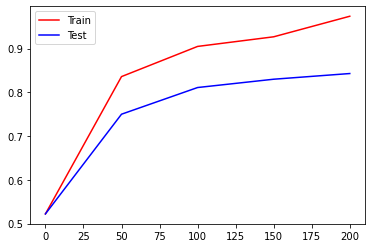

In [252]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_test,'b')
plt.legend(['Train','Test'])
plt.show()

In [253]:
classes = ['No Voice', 'Voice']
y_pred = CNN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.81      0.87      0.84       241
       Voice       0.84      0.77      0.80       219

    accuracy                           0.82       460
   macro avg       0.82      0.82      0.82       460
weighted avg       0.82      0.82      0.82       460



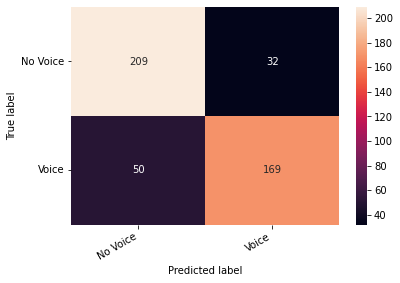

In [254]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [255]:
y_pred = CNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.88      0.82      0.85       211
       Voice       0.78      0.85      0.82       157

    accuracy                           0.84       368
   macro avg       0.83      0.84      0.84       368
weighted avg       0.84      0.84      0.84       368



In [256]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
